In [78]:
%matplotlib inline
import re
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import seaborn as sns

In [86]:
df = pd.read_csv("train 2.csv", encoding = "ISO-8859-1")

### Number of comments in each category

In [88]:
df_toxic = df.drop(['id', 'comment_text'], axis=1)
counts = []
categories = list(df_toxic.columns.values)
for i in categories:
    counts.append((i, df_toxic[i].sum()))
df_stats = pd.DataFrame(counts, columns=['category', 'number_of_comments'])
df_stats

,category,number_of_comments
0,toxic,15294
1,severe_toxic,1595
2,obscene,8449
3,threat,478
4,insult,7877
5,identity_hate,1405


Text(0.5,0,'category')

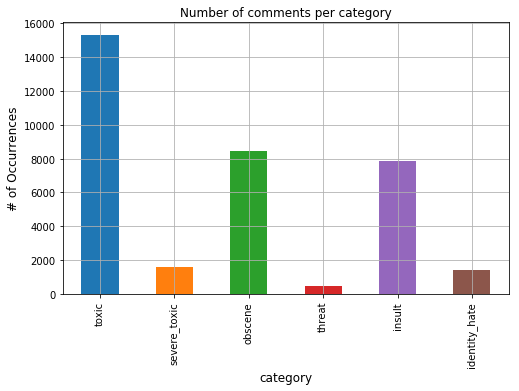

In [89]:
df_stats.plot(x='category', y='number_of_comments', kind='bar', legend=False, grid=True, figsize=(8, 5))
plt.title("Number of comments per category")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('category', fontsize=12)

### Multi-Label

How many comments have multiple labels?

Text(0.5,0,'# of categories')

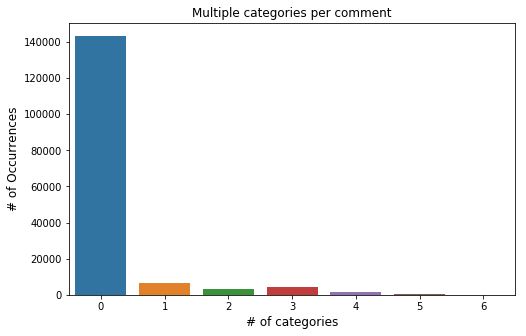

In [90]:
rowsums = df.iloc[:,2:].sum(axis=1)
x=rowsums.value_counts()

#plot
plt.figure(figsize=(8,5))
ax = sns.barplot(x.index, x.values)
plt.title("Multiple categories per comment")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('# of categories', fontsize=12)

Vast majority of the comment texts are not labeled.

The distribution of the number of words in comment texts.

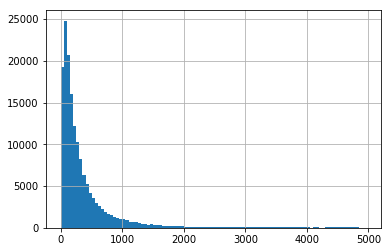

In [115]:
lens = df.comment_text.str.len()
lens.hist(bins = np.arange(0,5000,50))

Most of the comment text length are within 500 characters, with some outliers up to 5,000 characters long.

In [91]:
print('Percentage of comments that are not labelled:')
print(len(df[(df['toxic']==0) & (df['severe_toxic']==0) & (df['obscene']==0) & (df['threat']== 0) & (df['insult']==0) & (df['identity_hate']==0)]) / len(df))

Percentage of comments that are not labelled:
0.8983211235124177


There is no missing comment in comment text column.

In [92]:
print('Number of missing comments in comment text:')
df['comment_text'].isnull().sum()

Number of missing comments in comment text:


0

Have a peek the first comment, the text needs clean.

In [93]:
df['comment_text'][0]

"Explanation\rWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

In [94]:
categories = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

### Create a function to clean the text

In [95]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

### Clean up comment_text column 

In [96]:
df['comment_text'] = df['comment_text'].map(lambda com : clean_text(com))

Much better!

In [97]:
df['comment_text'][0]

'explanation why the edits made under my username hardcore metallica fan were reverted they were not vandalisms just closure on some gas after i voted at new york dolls fac and please do not remove the template from the talk page since i am retired now 89 205 38 27'

### Split to train and test sets

In [98]:
train, test = train_test_split(df, random_state=42, test_size=0.33, shuffle=True)

In [99]:
X_train = train.comment_text
X_test = test.comment_text
print(X_train.shape)
print(X_test.shape)

(106912,)
(52659,)


### Pipeline

scikit-learn provides a Pipeline utility to help automate machine learning workflows. Pipelines are very common in Machine Learning systems, since there is a lot of data to manipulate and many data transformations to apply. So we will utilize pipeline to train every classifier.

### OneVsRest multilabel strategy

The Multi-label algorithm accepts a binary mask over multiple labels. The result for each prediction will be an array of 0s and 1s marking which class labels apply to each row input sample.

### Naive Bayes

OneVsRest strategy can be used for multilabel learning, where a classifier is used to predict multiple labels for instance. Naive Bayes supports multi-class, but we are in a multi-label scenario, therefore, we wrapp Naive Bayes in the OneVsRestClassifier.

In [100]:
# Define a pipeline combining a text feature extractor with multi lable classifier
NB_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(MultinomialNB(
                    fit_prior=True, class_prior=None))),
            ])

In [101]:
for category in categories:
    print('... Processing {}'.format(category))
    # train the model using X_dtm & y
    NB_pipeline.fit(X_train, train[category])
    # compute the testing accuracy
    prediction = NB_pipeline.predict(X_test)
    print('Test accuracy is {}'.format(accuracy_score(test[category], prediction)))

... Processing toxic
Test accuracy is 0.9191401279933155
... Processing severe_toxic
Test accuracy is 0.9900112041626312
... Processing obscene
Test accuracy is 0.9514802787747584
... Processing threat
Test accuracy is 0.9971135038644866
... Processing insult
Test accuracy is 0.9517271501547694
... Processing identity_hate
Test accuracy is 0.9910556600011394


### LinearSVC

In [61]:
SVC_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(LinearSVC(), n_jobs=1)),
            ])

In [62]:
for category in categories:
    print('... Processing {}'.format(category))
    # train the model using X_dtm & y
    SVC_pipeline.fit(X_train, train[category])
    # compute the testing accuracy
    prediction = SVC_pipeline.predict(X_test)
    print('Test accuracy is {}'.format(accuracy_score(test[category], prediction)))

... Processing toxic
Test accuracy is 0.9599498661197516
... Processing severe_toxic
Test accuracy is 0.9906948479842003
... Processing obscene
Test accuracy is 0.9789019920621356
... Processing threat
Test accuracy is 0.9974173455629617
... Processing insult
Test accuracy is 0.9712299891756395
... Processing identity_hate
Test accuracy is 0.9919861752027194


### Logistic Regression

In [64]:
LogReg_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=1)),
            ])
for category in categories:
    print('... Processing {}'.format(category))
    # train the model using X_dtm & y
    LogReg_pipeline.fit(X_train, train[category])
    # compute the testing accuracy
    prediction = LogReg_pipeline.predict(X_test)
    print('Test accuracy is {}'.format(accuracy_score(test[category], prediction)))

... Processing toxic
Test accuracy is 0.9548415275641391
... Processing severe_toxic
Test accuracy is 0.9910556600011394
... Processing obscene
Test accuracy is 0.9761104464573956
... Processing threat
Test accuracy is 0.9973793653506523
... Processing insult
Test accuracy is 0.9687612753755294
... Processing identity_hate
Test accuracy is 0.991758293928863
